In [1]:
import geopandas as gpd
import pickle
from gerrychain import Graph, Partition
import matplotlib.pyplot as plt
import maup
import pandas
import requests
from tqdm import tqdm
import numpy as np

## Create block level shapefile

In [2]:
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

In [3]:
def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

In [4]:
def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pandas.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data

In [9]:
def tract_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=tract:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract"]})
    data = pandas.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"]
    return data

In [6]:
def tract_data_for_state(state_fips):
    county_fips_codes = counties(state_fips)
    return pandas.concat(
        [
            tract_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [7]:
def block_data_for_state(state_fips):
    county_fips_codes = counties(state_fips)
    return pandas.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [11]:
tracts = tract_data_for_state(41)


100%|██████████| 36/36 [00:28<00:00,  1.28it/s]


In [44]:
tracts = pandas.merge(tract_shape, tracts, left_on="GEOID", right_on="geoid")

In [47]:
tracts.to_file("data/OR_tracts/OR_tracts.shp")

In [18]:
sum(tracts["TOTPOP"])

3831074

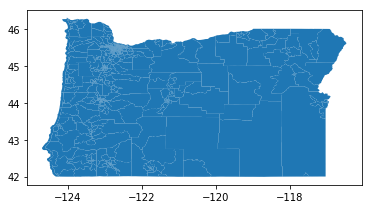

In [46]:
tracts.plot()

In [43]:
tract_shape.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,41,007,951100,41007951100,9511,Census Tract 9511,G5020,S,463149293,10768466,+45.8862020,-123.8372660,"POLYGON ((-123.973303 45.78384399999999, -123...."
1,41,007,990000,41007990000,9900,Census Tract 9900,G5020,S,0,470172211,+46.0763475,-123.9865578,"POLYGON ((-124.062056 45.789741, -124.054118 4..."
2,41,007,950900,41007950900,9509,Census Tract 9509,G5020,S,4669969,1904335,+45.9967172,-123.9255758,"POLYGON ((-123.955248 45.979199, -123.953539 4..."
3,41,007,951200,41007951200,9512,Census Tract 9512,G5020,S,1066541686,39185724,+45.9851300,-123.5121325,"POLYGON ((-123.700641 45.808415, -123.700313 4..."
4,41,007,950600,41007950600,9506,Census Tract 9506,G5020,S,185478229,5564204,+46.0631037,-123.8231889,"POLYGON ((-123.876789 46.015082, -123.876791 4..."


In [20]:
sum(block_data["TOTPOP"])

3831074

In [22]:
block_data.shape

(196621, 31)

In [19]:
block_data = block_data_for_state(41)


100%|██████████| 36/36 [01:46<00:00,  2.96s/it]


In [37]:
# tract_shape = gpd.read_file("data/tl_2010_01041_tract10/tl_2010_01041_tract10.shp")
tract_shape = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2012/TRACT/tl_2012_41_tract.zip")

In [40]:
tract_shape.shape

(834, 13)

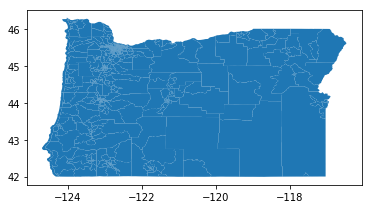

In [38]:
tract_shape.plot()

In [43]:
block_shape = gpd.read_file("data/tl_2010_41_tabblock10/tl_2010_41_tabblock10.shp")

In [58]:
block_data.columns

Index(['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ',
       'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN ',
       'H_ASIAN', 'H_NHPI ', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP',
       'NAME', 'state', 'county', 'tract', 'block', 'geoid'],
      dtype='object')

In [59]:
block_shape.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYP10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [62]:
blocks = pandas.merge(block_shape, block_data, left_on="GEOID10", right_on="geoid")

In [8]:
blocks = blocks.to_crs(precincts.crs)

In [ ]:
blocks.plot()

In [10]:
blocks.crs

{'init': 'epsg:2838'}

In [7]:
precincts.crs

{'init': 'epsg:2838'}

In [95]:
blocks.to_file("data/OR_blocks/OR_blocks.shp")

In [14]:
len(blocks)

196621

In [15]:
len(precincts)

1333

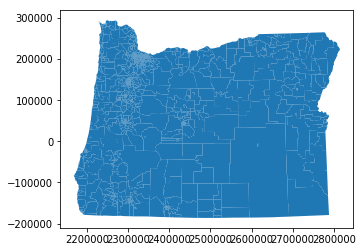

In [17]:
precincts.plot()

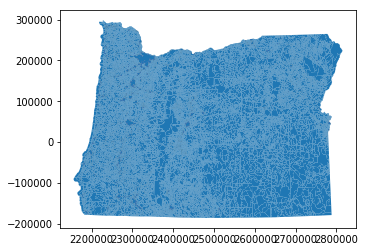

In [18]:
blocks.plot()

## Maup election data to blocks

In [34]:
bocks_w_pop = blocks[blocks["TOTPOP"] != 0]

In [24]:
precincts.head()

,State,County,Precinct,Pct_Name,Shape_Leng,Shape_Area,GOV18D,GOV18R,GOV18I,GOV18L,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,Oregon,Benton,OR_BENTON_01,Corvallis ONE,81174.073075,6.862338e+07,2161,1015,70,35,...,4884,167,4195,44,14,324,13,12,113,"POLYGON ((2276647.472999998 102875.1359999865,..."
1,Oregon,Benton,OR_BENTON_10,Philomath,79174.493326,5.674381e+07,1172,918,101,54,...,3234,184,2897,14,33,37,1,2,61,"POLYGON ((2272992.265600001 102631.1809999899,..."
2,Oregon,Benton,OR_BENTON_12,Adair Village,26305.883519,1.202054e+07,177,172,15,7,...,511,24,454,3,5,9,0,0,11,"POLYGON ((2284829.747799999 116238.0853999885,..."
3,Oregon,Benton,OR_BENTON_13,Monroe,23174.129695,1.386360e+07,67,138,14,3,...,482,56,409,1,3,1,0,0,11,"POLYGON ((2277308.593900001 76950.94069999122,..."
4,Oregon,Benton,OR_BENTON_14,Alsea School,338231.820264,3.844660e+09,152,276,37,5,...,808,19,747,1,7,8,0,5,16,"POLYGON ((2261534.428799999 91152.32719998759,..."


In [5]:
precincts = gpd.read_file("data/OR_precincts/OR_precincts.shp")

In [12]:
precincts.columns

Index(['State', 'County', 'Precinct', 'Pct_Name', 'Shape_Leng', 'Shape_Area',
       'GOV18D', 'GOV18R', 'GOV18I', 'GOV18L', 'GOV18C', 'USH18D', 'USH18R',
       'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G', 'SEN16D', 'SEN16R',
       'USH16D', 'USH16R', 'GOV16D', 'GOV16R', 'GOV16I', 'GOV16L', 'AG16D',
       'AG16R', 'SOS16D', 'SOS16R', 'SOS16I', 'SOS16G', 'SOS16L', 'CD',
       'HDIST', 'SEND', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [39]:
election_columns = ['GOV18D', 'GOV18R', 'GOV18I', 'GOV18L', 'GOV18C', 
                    'USH18D', 'USH18R', 'PRES16D', 'PRES16R', 'PRES16L', 
                    'PRES16G', 'SEN16D', 'SEN16R', 'USH16D', 'USH16R', 
                    'GOV16D', 'GOV16R', 'GOV16I', 'GOV16L', 'AG16D', 'AG16R',
                    'SOS16D', 'SOS16R', 'SOS16I', 'SOS16G', 'SOS16L']

In [36]:
assignment = maup.assign(bocks_w_pop, precincts)

In [37]:
weights = blocks.VAP / assignment.map(precincts.VAP)

In [40]:
prorated = maup.prorate(assignment, precincts[election_columns], weights)

In [58]:
blocks[election_columns] = 0
blocks[election_columns] = prorated

In [ ]:
for i in blocks.index:
    if i not in  prorated.index:
        blocks[election_columns][i]

In [87]:
for e in election_columns:
    blocks[e] = blocks[e].apply(lambda x: 0 if np.isnan(x) else x)

In [89]:
blocks[election_columns].head()

,GOV18D,GOV18R,GOV18I,GOV18L,GOV18C,USH18D,USH18R,PRES16D,PRES16R,PRES16L,...,GOV16R,GOV16I,GOV16L,AG16D,AG16R,SOS16D,SOS16R,SOS16I,SOS16G,SOS16L
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.183529,0.583529,0.117647,0.056471,0.018824,0.202353,0.607059,0.216471,0.8,0.089412,...,0.658824,0.056471,0.023529,0.395294,0.607059,0.282353,0.621176,0.070588,0.018824,0.047059


In [93]:
print("Blocks:", sum(blocks["PRES16D"]),"Precincts:", sum(precincts["PRES16D"]))

Blocks: 1002351.7095954556 Precincts: 1002106


In [94]:
print("Blocks:", sum(blocks["PRES16R"]),"Precincts:", sum(precincts["PRES16R"]))

Blocks: 782089.8770670564 Precincts: 782403


## Build Block Dual Graph

In [ ]:
graph = Graph.from_file("data/OR_blocks/OR_blocks.shp")

In [ ]:
with open("data/OR_blocks/OR_block_graph.p", "wb") as f_out:
    pickle.dump(graph, f_out)